In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16008, done.
remote: Total 16008 (delta 0), reused 0 (delta 0), pack-reused 16008
Receiving objects: 100% (16008/16008), 14.56 MiB | 11.16 MiB/s, done.
Resolving deltas: 100% (11011/11011), done.


In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
!pip install -qr requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.6/612.6 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd

from tqdm import tqdm
from pathlib import Path
from PIL import Image


In [ ]:
np.random.seed(42)

In [ ]:
!mkdir ../choicedatasets

In [ ]:
data_dir = '/content/drive/MyDrive/MilAirDataset'

In [ ]:


images_folder = '/content/drive/MyDrive/MilAirDataset/images'
label_folder = '/content/drive/MyDrive/MilAirDataset/labels'


if os.path.exists(images_folder) and os.listdir(images_folder) and os.path.exists(label_folder) and os.listdir(label_folder):
    print("Yolo dataset prepared!")
    image_dir = data_dir + '/images'
    label_dir = data_dir + '/labels'
    class_names = sorted(['F16','F15','F18','F35','C130'])
    class2idx = {class_name: i for i, class_name in enumerate(class_names)}
    print(class2idx)
else:
    print("One or both dataset folders do not exist or are empty.")
    print("Preparing dataset.")
    data_dir = Path(data_dir)


    image_paths = []
    annotation_paths = []
    for file_name in sorted(os.listdir(data_dir / 'dataset')):
        file_name = Path(file_name)
        if file_name.suffix == '.jpg':
            image_paths.append(data_dir / 'dataset' / file_name)
        if file_name.suffix == '.csv':
            annotation_paths.append(data_dir / 'dataset' / file_name)

    #class_names = sorted(os.listdir(data_dir / 'crop'))
    class_names = sorted(['F16','F15','F18','F35','C130'])

    class2idx = {class_name: i for i, class_name in enumerate(class_names)}

    def convert_bboxes_to_yolo_format(df: pd.DataFrame, class2idx: dict):
        df = df[df['class'].isin(class2idx.keys())]
        df['class'] = df['class'].apply(lambda x: class2idx[x]).values
        df['xmin'] = (df['xmin'] / df['width']).values
        df['ymin'] = (df['ymin'] / df['height']).values
        df['xmax'] = (df['xmax'] / df['width']).values
        df['ymax'] = (df['ymax'] / df['height']).values
        df['xc']   = (df['xmin'] + df['xmax']) / 2
        df['yc']   = (df['ymin'] + df['ymax']) / 2
        df['w']    = (df['xmax'] - df['xmin'])
        df['h']    = (df['ymax'] - df['ymin'])
        df.drop(
            ['filename', 'width', 'height', 'xmin', 'xmax', 'ymin', 'ymax'],
            axis=1,
            inplace=True
        )
        return df

    image_dir = data_dir / 'images'
    label_dir = data_dir / 'labels'
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for annotation_path in tqdm(annotation_paths):
        image_id = annotation_path.parts[-1].split('.')[0]
        annotation_df = pd.read_csv(annotation_path)
        contains_class_names = annotation_df['class'].isin(class_names)
        filtered_df = annotation_df[contains_class_names]
        filenames_array = filtered_df['filename'].to_numpy()
        annotation_df = convert_bboxes_to_yolo_format(filtered_df, class2idx)
        if not annotation_df.empty:
          print("Writing label...")
          with open(Path(label_dir) / f'{image_id}.txt', 'w') as f:
            f.write(annotation_df.to_string(header=False, index=False))

    image_filenames = []

    for file_name in sorted(os.listdir('/content/drive/MyDrive/MilAirDataset/labels')):
      file_name = Path(file_name)
      if file_name.suffix == '.txt':
        image_file = str(file_name)[:-4] + ".jpg"
        image_filenames.append('/content/drive/MyDrive/MilAirDataset/dataset/' + image_file)

    for image_path in image_filenames:
      shutil.copy(str(image_path), image_dir)


Yolo dataset prepared!
{'C130': 0, 'F15': 1, 'F16': 2, 'F18': 3, 'F35': 4}


In [ ]:
from PIL import Image
import os

if os.path.exists(images_folder) and os.listdir(images_folder):
  print("Image sizes correct")

else:
  folder_path = "/content/drive/MyDrive/MilAirDataset/images"
  target_height = 640

  for filename in os.listdir(folder_path):
      if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
          image_path = os.path.join(folder_path, filename)
          try:
            image = Image.open(image_path)
            width, height = image.size
            aspect_ratio = width / height
            new_width = int(target_height * aspect_ratio)
            resized_image = image.resize((new_width, target_height))
            resized_image = resized_image.convert('RGB')
            resized_image.save(image_path)
            image.close()
          except:
            print("Error opening or resizing image "+filename)




Image sizes correct


Dataset visalization

In [ ]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)

from PIL import Image
from matplotlib.patches import Rectangle

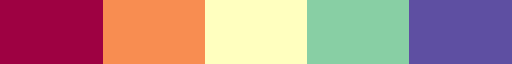

In [ ]:
cmap = plt.get_cmap('Spectral', len(class2idx))
sample_ids = np.random.randint(0, len(os.listdir(image_dir)), 16)
idx2class = {class_id: class_name for class_name, class_id in class2idx.items()}
cmap

In [ ]:
image_paths = [Path(image_dir) / image_path for image_path in sorted(os.listdir(image_dir))]
label_paths = [Path(label_dir) / label_path for label_path in sorted(os.listdir(label_dir))]
image_paths

In [ ]:
image = np.array(Image.open(image_paths[sample_ids[0]]))
bboxes = np.loadtxt(label_paths[sample_ids[0]], ndmin=2)

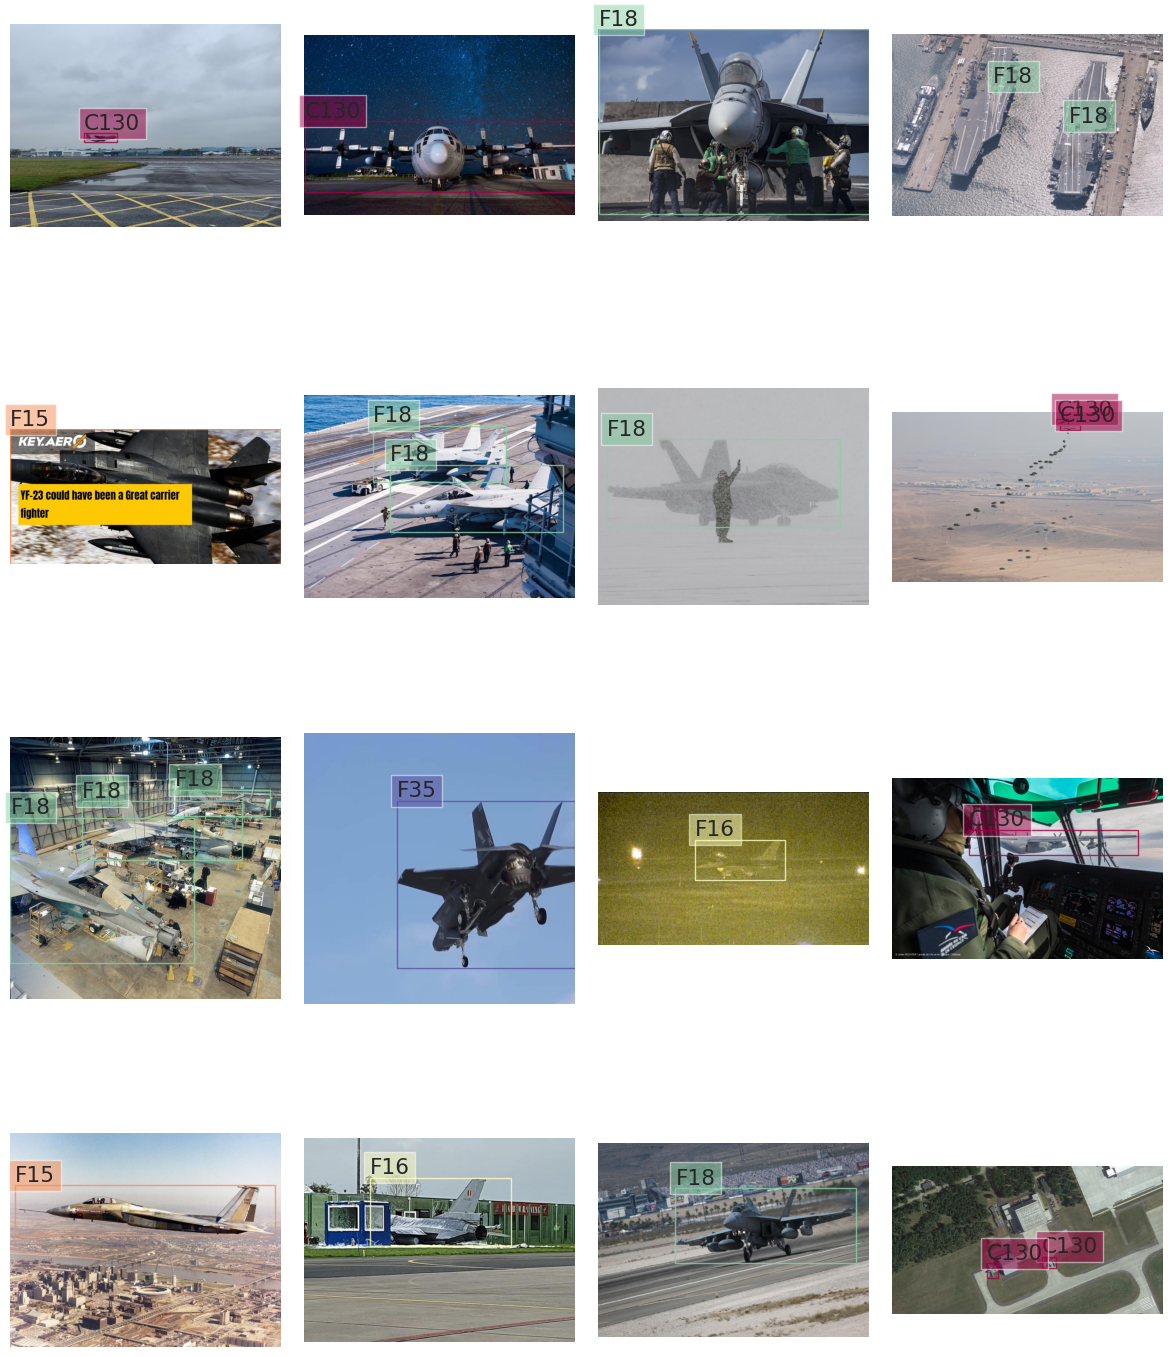

In [ ]:
import math

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 4 * 4))

for i, sample_id in enumerate(sample_ids):
    row = math.floor(i / 4)
    col = i % 4


    image = np.array(Image.open(image_paths[sample_id]))
    bboxes = np.loadtxt(label_paths[sample_id], ndmin=2)

    image_h, image_w = image.shape[:2]

    for bbox in bboxes:
        class_id, xc, yc, w, h = bbox
        xc, yc, w, h = image_w * xc, image_h * yc, image_w * w, image_h * h
        xmin, ymin = xc - w / 2, yc - h / 2
        rect = Rectangle(
            (xmin, ymin),
            w, h,
            linewidth=1,
            edgecolor=cmap(int(class_id)),
            facecolor='none',
            alpha=0.8
        )
        ax[row, col].add_patch(rect)
        ax[row, col].text(
            xmin, ymin,
            idx2class[int(class_id)],
            ha='left', va='bottom',
            bbox={'facecolor': cmap(int(class_id)), 'alpha': 0.5}
        )

    ax[row, col].imshow(image)
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()


Dataset split

In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split

In [ ]:
image_paths = [f'images/{image_path}' for image_path in sorted(os.listdir(image_dir))]

In [ ]:
train_size = 0.8

In [ ]:
train_image_paths, val_image_paths = train_test_split(
    image_paths, train_size=train_size, random_state=42, shuffle=True)

train_path = '/content/drive/MyDrive/MilAirDataset/train_split.txt'
val_path = '/content/drive/MyDrive/MilAirDataset/val_split.txt'

#train split
if os.path.exists(train_path):
    print("Train split file exists")
else:
    print("File does not exist.")
    with open(data_dir / 'train_split.txt', 'w') as f:
      f.writelines(f'./{image_path}\n' for image_path in train_image_paths)

#val split
if os.path.exists(val_path):
    print("Val split file exists")
else:
    print("File does not exist.")
    with open(data_dir / 'val_split.txt', 'w') as f:
        f.writelines(f'./{image_path}\n' for image_path in val_image_paths)




Train split file exists
Val split file exists


Split visalization accros classes

In [ ]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
# set fonttype
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42

%matplotlib inline

Total train: 3831
Total train: 964
0: C130 1: F15 2: F16 3: F18 4: F35 

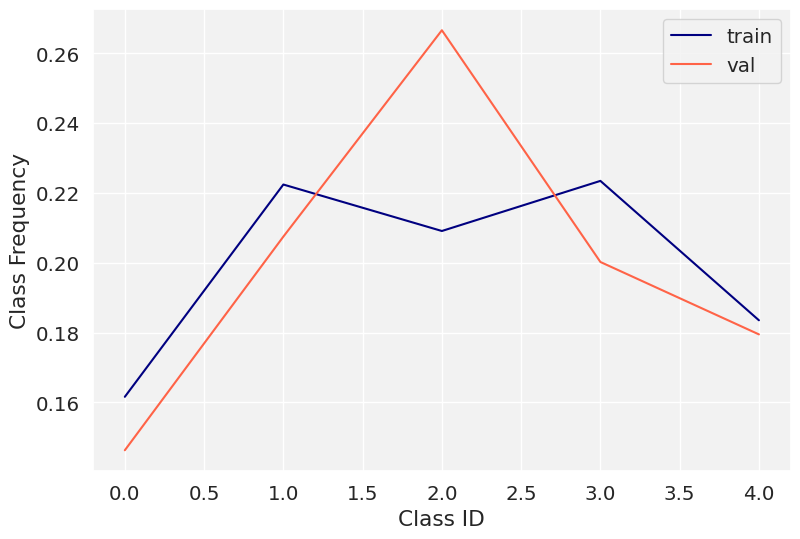

In [ ]:
class_counter = {'train': Counter(), 'val': Counter()}
class_freqs = {}

with open(data_dir + '/train_split.txt', 'r') as f:
    for line in f:
        image_id = line.split('/')[-1].split('.')[0]
        df = np.loadtxt(label_dir + f'/{image_id}.txt',ndmin=2)
        class_counter['train'].update(df[:, 0].astype(int))
# get class freqs
total_train = sum(class_counter['train'].values())
class_freqs['train'] = {k: v / total_train for k, v in class_counter['train'].items()}

with open(data_dir + '/val_split.txt', 'r') as f:
    for line in f:
        image_id = line.split('/')[-1].split('.')[0]
        df = np.loadtxt(label_dir + f'/{image_id}.txt',ndmin=2)
        class_counter['val'].update(df[:, 0].astype(int))
# get class freqs
total_val = sum(class_counter['val'].values())
class_freqs['val'] = {k: v / total_val for k, v in class_counter['val'].items()}

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(range(5), [class_freqs['train'][i] for i in range(5)], color='navy', label='train');
ax.plot(range(5), [class_freqs['val'][i] for i in range(5)], color='tomato', label='val');
ax.legend();
ax.set_xlabel('Class ID');
ax.set_ylabel('Class Frequency');
class2idx
print("Total train: " + str(total_train))
print("Total val: " + str(total_val))
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}", end=" ")

Training

In [ ]:
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

0: C130
1: F15
2: F16
3: F18
4: F35


In [ ]:
data_yaml = '''
path: /content/drive/MyDrive/MilAirDataset  # dataset root dir
train: train_split.txt  # train images (relative to 'path')
val: val_split.txt  # val images (relative to 'path')
test:  # test images

# Classes
names:
  0: C130
  1: F15
  2: F16
  3: F18
  4: F35
'''

In [ ]:
with open('data/MilitaryAircraft.yaml', 'w') as f:
    f.write(data_yaml)

In [ ]:
train_script_str = '''
#!/bin/bash

# total batch size
BATCH_SIZE=70

RUN_NAME=train_mil_air_yolov5

python train.py \
    \
    --hyp data/hyps/hyp.scratch-low.yaml \
    \
    --img 640 \
    --batch ${BATCH_SIZE} \
    --epochs 50 \
    --data MilitaryAircraft.yaml \
    --weights yolov5s.pt \
    \
    --project runs/MilitaryAircraft \
    --exist-ok \
    --name ${RUN_NAME}
'''

In [ ]:
with open('run_train.sh', 'w') as f:
    f.write(train_script_str)

!chmod +x run_train.sh
! ./run_train.sh

train: weights=yolov5s.pt, cfg=, data=MilitaryAircraft.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=70, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/MilitaryAircraft, name=train_mil_air_yolov5, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-187-g0004c74 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0